# Import Library

In [77]:
!pip install keras_tuner

In [78]:
from google.colab import drive
import os
import holidays
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing & Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

print("Library berhasil diimpor.")

Library berhasil diimpor.


# Data Preparation

## Load Data

In [79]:
# Definisikan ID Toko Representatif untuk FnB
TARGET_STORE_ID = 12

# Reset folder tuner
tuner_path = 'tuner_dir/fnb_lstm_tuning'
if os.path.exists(tuner_path):
    shutil.rmtree(tuner_path)
    print(f"Folder {tuner_path} dihapus. Memulai sesi training baru.")

Folder tuner_dir/fnb_lstm_tuning dihapus. Memulai sesi training baru.


In [80]:
# Mount Google Drive
drive.mount('/content/drive')

# Tentukan path folder data Anda
base_path = '/content/drive/MyDrive/Magang Prima PTKI/data_dummy'

print(f"Drive berhasil terhubung. Mencari data di: {base_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive berhasil terhubung. Mencari data di: /content/drive/MyDrive/Magang Prima PTKI/data_dummy


In [81]:
# --- A. LOAD DATA DARI DRIVE ---
try:
    transactions_df = pd.read_csv(os.path.join(base_path, 'transactions.csv'))
    transaction_details_df = pd.read_csv(os.path.join(base_path, 'transaction_details.csv'))
    products_df = pd.read_csv(os.path.join(base_path, 'products.csv'))
    stores_df = pd.read_csv(os.path.join(base_path, 'stores.csv'))
    print("Semua file CSV berhasil dimuat dari Google Drive.")
except FileNotFoundError as e:
    print(f"Error: File tidak ditemukan di {base_path}. Pastikan nama file sesuai.")

Semua file CSV berhasil dimuat dari Google Drive.


## Merging Data

In [82]:
# --- B. MERGING DATA ---
# Gabungkan transaksi -> detail -> produk -> toko
df_merged = pd.merge(transactions_df, transaction_details_df, left_on='id', right_on='transactionId')
df_merged = pd.merge(df_merged, products_df[['id', 'productCategoryId']], left_on='productId', right_on='id', suffixes=('', '_prod'))
df_merged = pd.merge(df_merged, stores_df[['id', 'storeTypeId']], left_on='storeId', right_on='id', suffixes=('', '_store'))

In [83]:
# --- C. FILTERING FnB (ID 1) ---
# Filter berdasarkan storeTypeId = 1 (FnB) & storeId = 12
df_fnb = df_merged[df_merged['storeId'] == TARGET_STORE_ID].copy()
df_fnb['transactionDate'] = pd.to_datetime(df_fnb['transactionDate'])

In [84]:
print(f"Data FnB (ID 1) berhasil difilter. Jumlah data: {len(df_fnb)}")

Data FnB (ID 1) berhasil difilter. Jumlah data: 22085


## Data Cleaning

In [85]:
# --- D. AGREGASI HARIAN ---
time_series_fnb = df_fnb.groupby(df_fnb['transactionDate'].dt.date)['subtotal'].sum().reset_index()
time_series_fnb.columns = ['date', 'revenue']
time_series_fnb['date'] = pd.to_datetime(time_series_fnb['date'])
time_series_fnb.set_index('date', inplace=True)

In [86]:
# Pastikan tidak ada tanggal yang terlewat (isi dengan 0 jika ada hari tanpa transaksi)
all_days = pd.date_range(start=time_series_fnb.index.min(), end=time_series_fnb.index.max(), freq='D')
time_series_fnb = time_series_fnb.reindex(all_days, fill_value=0)

In [87]:
# --- E. HANDLING OUTLIERS (IQR METHOD) ---
Q1 = time_series_fnb['revenue'].quantile(0.25)
Q3 = time_series_fnb['revenue'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [88]:
# Clipping outliers agar tidak ekstrem
time_series_fnb['revenue_clean'] = time_series_fnb['revenue'].clip(lower=lower_bound, upper=upper_bound)

print("Data Preparation & Cleaning Selesai.")
print(time_series_fnb)

Data Preparation & Cleaning Selesai.
            revenue  revenue_clean
2025-04-17  6014000        6014000
2025-04-18  4671000        4671000
2025-04-19  4697000        4697000
2025-04-20  4629000        4629000
2025-04-21  3415000        3415000
...             ...            ...
2026-01-08  4888000        4888000
2026-01-09  3770000        3770000
2026-01-10  5861000        5861000
2026-01-11  5533000        5533000
2026-01-12  4526000        4526000

[271 rows x 2 columns]


# Exploratory Data Analysis (EDA)

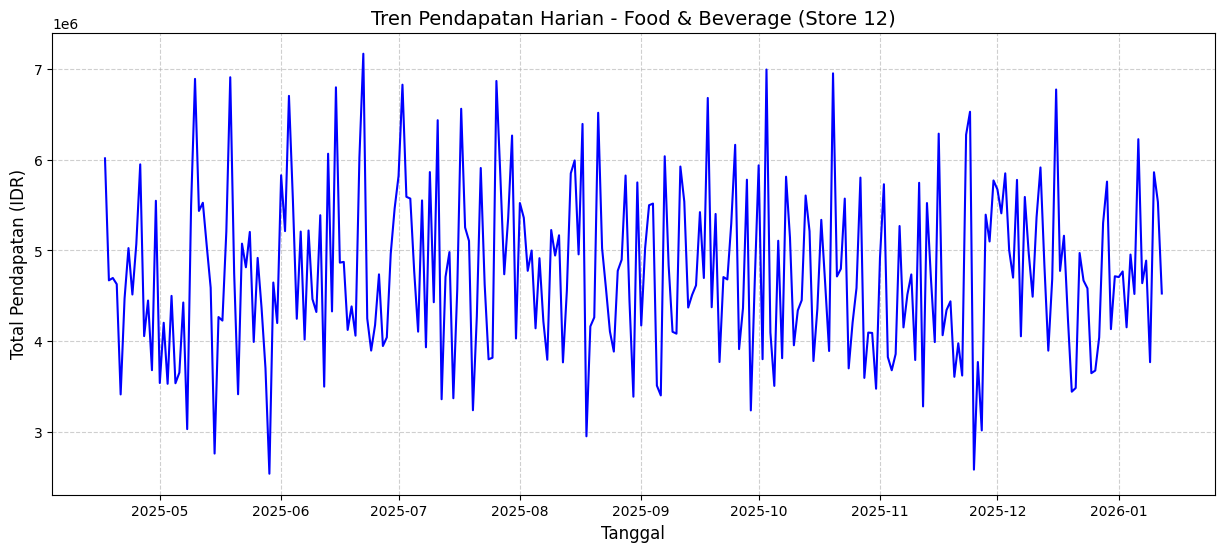

In [89]:
# 1. Tren Pendapatan Harian
plt.figure(figsize=(15, 6))
plt.plot(time_series_fnb.index, time_series_fnb['revenue_clean'], color='blue', linewidth=1.5)
plt.title('Tren Pendapatan Harian - Food & Beverage (Store 12)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan (IDR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

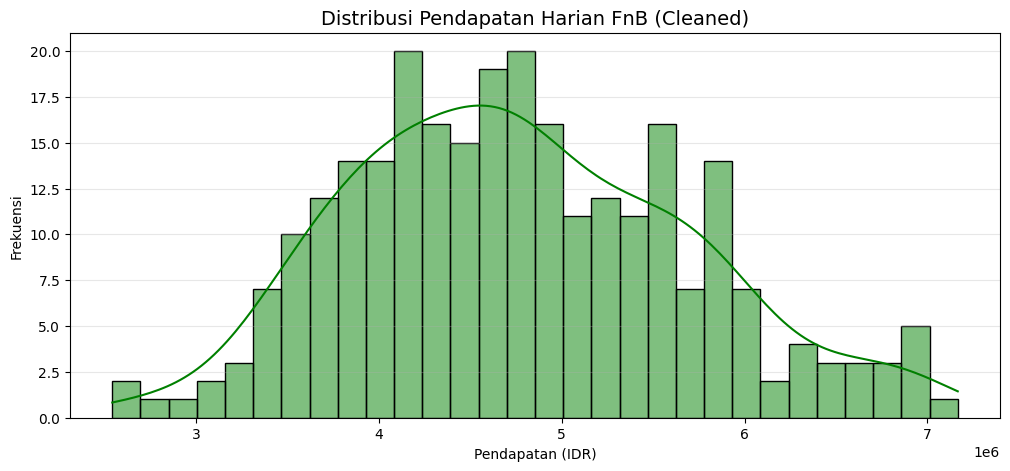

In [90]:
# --- A. VISUALISASI DISTRIBUSI ---
# Untuk melihat apakah data memiliki sebaran yang normal atau condong ke arah tertentu
plt.figure(figsize=(12, 5))
sns.histplot(time_series_fnb['revenue_clean'], kde=True, color='green', bins=30)
plt.title('Distribusi Pendapatan Harian FnB (Cleaned)', fontsize=14)
plt.xlabel('Pendapatan (IDR)')
plt.ylabel('Frekuensi')
plt.grid(axis='y', alpha=0.3)
plt.show()

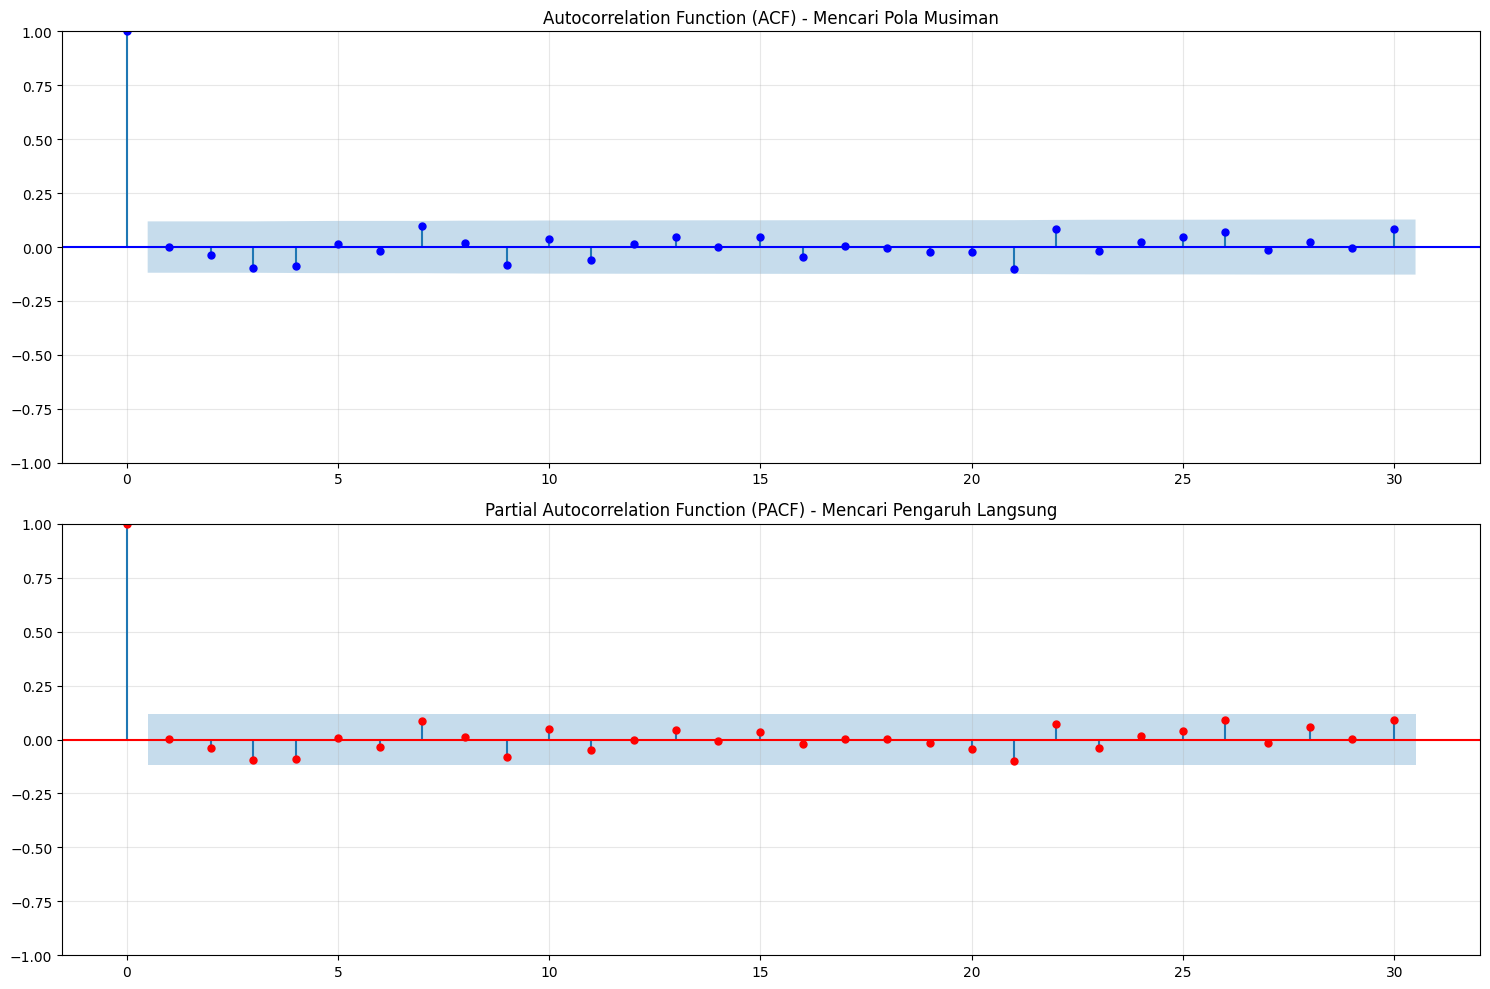

In [91]:
# --- B. ANALISIS AUTOKORELASI (PENTING!) ---
# ACF: Melihat korelasi antara pendapatan hari ini dengan hari-hari sebelumnya (lags)
# PACF: Melihat korelasi langsung tanpa pengaruh hari di antaranya
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Kita gunakan lags=30 untuk melihat pola dalam 1 bulan
plot_acf(time_series_fnb['revenue_clean'], lags=30, ax=ax1, color='blue')
ax1.set_title('Autocorrelation Function (ACF) - Mencari Pola Musiman', fontsize=12)
ax1.grid(True, alpha=0.3)

plot_pacf(time_series_fnb['revenue_clean'], lags=30, ax=ax2, color='red')
ax2.set_title('Partial Autocorrelation Function (PACF) - Mencari Pengaruh Langsung', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [92]:
# 5. Ringkasan Statistik
stats = time_series_fnb['revenue_clean'].describe()
print("="*45)
print("   RINGKASAN STATISTIK PENDAPATAN Makanan dan Minuman")
print("="*45)
print(f"Jumlah Data (Hari)  : {stats['count']:,.0f}")
print(f"Rata-rata Harian    : Rp {stats['mean']:,.2f}")
print(f"Standar Deviasi     : Rp {stats['std']:,.2f}")
print(f"Pendapatan Minimum  : Rp {stats['min']:,.2f}")
print(f"Median (P50)        : Rp {stats['50%']:,.2f}")
print(f"Pendapatan Maksimum : Rp {stats['max']:,.2f}")
print("="*45)

   RINGKASAN STATISTIK PENDAPATAN Makanan dan Minuman
Jumlah Data (Hari)  : 271
Rata-rata Harian    : Rp 4,765,848.71
Standar Deviasi     : Rp 924,847.33
Pendapatan Minimum  : Rp 2,542,000.00
Median (P50)        : Rp 4,697,000.00
Pendapatan Maksimum : Rp 7,166,000.00


# Preprocessing Data

## Feature Engineering

(Menambah Konteks Waktu)

In [93]:
# 1. Fitur Waktu & Tren (Rolling Avg)
id_holidays = holidays.Indonesia(years=[2025, 2026])
time_series_fnb['is_holiday'] = time_series_fnb.index.strftime('%Y-%m-%d').isin(id_holidays).astype(int)
# B. Tambahkan fitur Payday (Siklus gajian Balikpapan: tgl 25 - 5)
time_series_fnb['is_payday'] = time_series_fnb.index.day.map(lambda x: 1 if x >= 25 or x <= 5 else 0)
# C. Tambahkan fitur Weekend
time_series_fnb['is_weekend'] = time_series_fnb.index.weekday.map(lambda x: 1 if x >= 5 else 0)
# D. Tambahkan Rolling Average 7 hari (Tren mingguan)
time_series_fnb['rolling_avg_7d'] = time_series_fnb['revenue_clean'].rolling(window=7).mean()

In [94]:
# 2. Membuat Kolom Lag (AI melihat ke belakang lewat kolom ini)
for i in range(1, 8):
    time_series_fnb[f'lag_{i}'] = time_series_fnb['revenue_clean'].shift(i)

In [95]:
# Update Feature Engineering (Menambah Day of Month)
time_series_fnb['day_of_month'] = time_series_fnb.index.day

In [96]:
# 3. Hapus baris NaN akibat shifting dan rolling
time_series_fnb.dropna(inplace=True)

In [97]:
# 4. Definisikan Features (X) dan Target (y)
# Perhatikan: Kita TIDAK memasukkan 'revenue_clean' ke dalam features X
features = [f'lag_{i}' for i in range(1, 8)] + ['is_holiday', 'is_payday', 'is_weekend', 'rolling_avg_7d', 'day_of_month']
X_data = time_series_fnb[features]
y_data = time_series_fnb['revenue_clean']

print(f"Feature Engineering selesai. Total fitur: {len(features)}")

Feature Engineering selesai. Total fitur: 12


## Scaling

In [98]:
# A. Inisialisasi Scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [99]:
# B. Fit & Transform
# Kita langsung transform dataframe X_data dan Series y_data
X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(y_data.values.reshape(-1, 1))

In [100]:
# C. Reshaping untuk Conv1D & LSTM
# Format: (samples, time_steps, features)
# Karena lag sudah jadi kolom, kita gunakan time_steps = 1
X_final = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_final = y_scaled

In [101]:
print(f"Shape data input FINAL: {X_final.shape}") # Harus (Sampel, 1, 11)
print(f"Shape data target FINAL: {y_final.shape}")

Shape data input FINAL: (264, 1, 12)
Shape data target FINAL: (264, 1)


## Splitting Data (Train & Test)

In [102]:
train_size = int(len(X_final) * 0.8)

X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_final[:train_size], y_final[train_size:]

print(f"Data Latihan: {len(X_train)} hari")
print(f"Data Uji: {len(X_test)} hari")

Data Latihan: 211 hari
Data Uji: 53 hari


# Modeling

In [103]:
def model_builder(hp):
    model = Sequential()

    # 1. CNN Layer
    # REVISI: kernel_size dikunci ke 1 karena X_train hanya memiliki 1 time_step
    model.add(Conv1D(
        filters=hp.Int("conv_filters", min_value=32, max_value=128, step=16),
        kernel_size=1,
        activation='relu',
        padding='same',
        input_shape=(X_train.shape[1], X_train.shape[2]) # (1, 11)
    ))

    # REVISI: MaxPooling1D dengan pool_size=1 (agar tidak error pada dimensi kecil)
    model.add(MaxPooling1D(pool_size=1))

    # 2. Bi-LSTM Layer
    model.add(Bidirectional(
        LSTM(
            units=hp.Int("bilstm_units", min_value=32, max_value=128, step=16),
            return_sequences=True
        )
    ))
    model.add(Dropout(rate=hp.Float("dropout_1", min_value=0.2, max_value=0.5, step=0.1)))

    # 3. LSTM Layer Kedua
    model.add(LSTM(
        units=hp.Int("lstm_units", min_value=16, max_value=64, step=16),
        return_sequences=False
    ))
    model.add(Dropout(rate=hp.Float("dropout_2", min_value=0.2, max_value=0.5, step=0.1)))

    # 4. Dense Layers
    model.add(Dense(units=hp.Int("dense_units", min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

# Inisialisasi Tuner untuk mencari kombinasi saraf terbaik
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10, # Mencoba 10 kombinasi arsitektur berbeda
    directory='tuner_dir',
    project_name='fnb_lstm_tuning',
    overwrite=True
)

# Early Stopping: Berhenti jika model mulai menghafal (overfit)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Memulai proses Hyperparameter Tuning...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

# Mengambil model terbaik hasil tuning
best_model = tuner.get_best_models(num_models=1)[0]
print("Tuning Selesai. Model terbaik telah dipilih.")
best_model.summary()

Trial 10 Complete [00h 00m 17s]
val_loss: 0.017615916207432747

Best val_loss So Far: 0.009559057652950287
Total elapsed time: 00h 03m 12s
Tuning Selesai. Model terbaik telah dipilih.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,233 (1.34 MB)

 Trainable params: 351,233 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation & Visualization

In [104]:
# Pelatihan model terbaik
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0144 - mae: 0.0917 - val_loss: 0.0113 - val_mae: 0.0775
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0078 - mae: 0.0681 - val_loss: 0.0108 - val_mae: 0.0799
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068 - mae: 0.0645 - val_loss: 0.0125 - val_mae: 0.0852
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0073 - mae: 0.0655 - val_loss: 0.0104 - val_mae: 0.0765
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - mae: 0.0532 - val_loss: 0.0114 - val_mae: 0.0828
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0061 - mae: 0.0626 - val_loss: 0.0081 - val_mae: 0.0704
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069 - mae: 0.0658 - val_loss: 0.0147 - val_mae: 0.1068
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0103 - mae: 0.0824 - val_loss: 0.0115 - val_mae: 0.0896
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - lo

In [105]:
# 1. Melakukan Prediksi
y_pred_scaled = best_model.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step


In [106]:
# 2. Mengembalikan skala (Inverse Scale) ke nilai Rupiah asli
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_test).ravel()

In [107]:
# 3. Menghitung Metrik Evaluasi
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100 # Dalam persen
r2 = r2_score(y_actual, y_pred)

In [108]:
print("="*30)
print("HASIL EVALUASI MODEL FnB")
print("="*30)
print(f"Mean Absolute Error (MAE)  : Rp {mae:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape:.2f}%")
print(f"R2-Score (Goodness of Fit) : {r2:.4f}")
print("="*30)

HASIL EVALUASI MODEL FnB
Mean Absolute Error (MAE)  : Rp 168,886.38
Mean Absolute Percentage Error (MAPE) : 4.00%
R2-Score (Goodness of Fit) : 0.9366


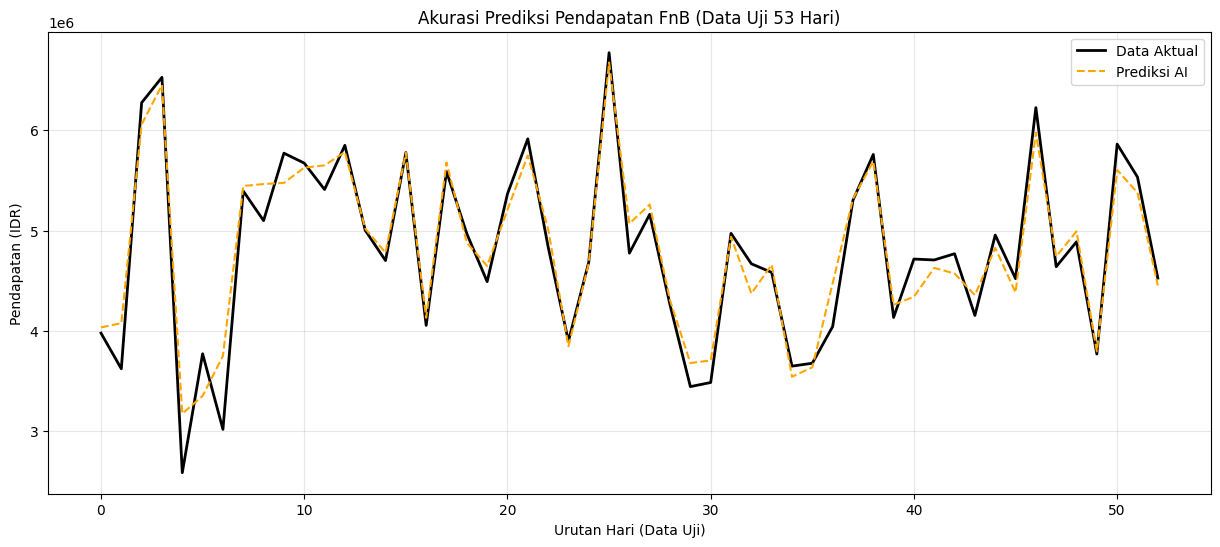

In [109]:
# 4. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Data Aktual', color='black', linewidth=2)
plt.plot(y_pred, label='Prediksi AI', color='orange', linestyle='--')
plt.title('Akurasi Prediksi Pendapatan FnB (Data Uji 53 Hari)')
plt.ylabel('Pendapatan (IDR)')
plt.xlabel('Urutan Hari (Data Uji)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

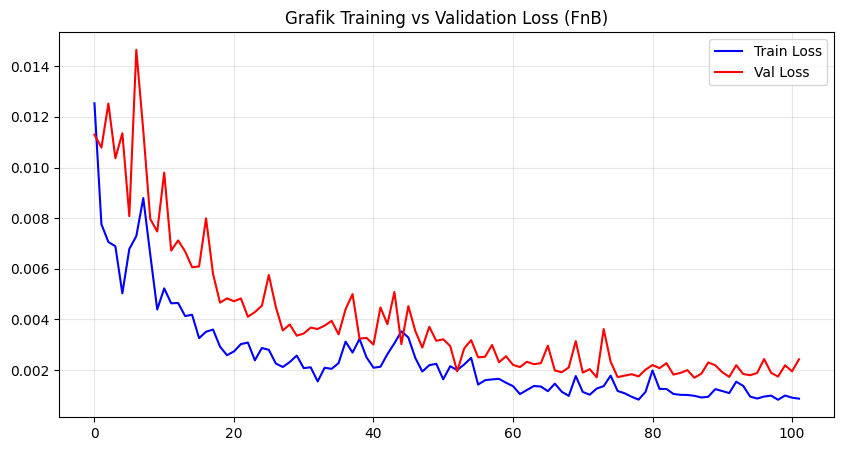

In [110]:
# 5. Visualisasi 2: Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.title('Grafik Training vs Validation Loss (FnB)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save Model

In [111]:
# 1. Simpan Model Terlatih
model_save_path = f'/content/drive/MyDrive/Magang Prima PTKI/models/fnb/model_fnb_store_{TARGET_STORE_ID}.keras'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
best_model.save(model_save_path)

# 2. Simpan Scaler (Sangat penting agar skala input di file forecasting nanti sama)
joblib.dump(scaler_X, f'/content/drive/MyDrive/Magang Prima PTKI/models/fnb/scaler_X_fnb.pkl')
joblib.dump(scaler_y, f'/content/drive/MyDrive/Magang Prima PTKI/models/fnb/scaler_y_fnb.pkl')

print(f"Model dan Scaler berhasil disimpan di: {os.path.dirname(model_save_path)}")

Model dan Scaler berhasil disimpan di: /content/drive/MyDrive/Magang Prima PTKI/models/fnb


# Kode Inference Dengan Analisis Bisnis

In [112]:
# 1. Load Model & Scaler
model = load_model('/content/drive/MyDrive/Magang Prima PTKI/models/fnb/model_fnb_store_12.keras')
scaler_X = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/fnb/scaler_X_fnb.pkl')
scaler_y = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/fnb/scaler_y_fnb.pkl')

In [113]:
def get_forecast_7_days_stabilized_fnb(model, df_historical, scaler_X, scaler_y):
    # Ambil data 7 hari terakhir
    current_lags = df_historical['revenue_clean'].tail(7).tolist()

    # Hitung rata-rata per hari dalam seminggu (Stabilizer pola harian FnB)
    weekly_pattern = df_historical.groupby(df_historical.index.dayofweek)['revenue_clean'].mean()

    predictions = []
    dates = []
    last_date = df_historical.index[-1]
    id_holidays = holidays.Indonesia(years=[last_date.year, last_date.year + 1])

    print("="*60)
    print(f"   PREDIKSI OPERASIONAL FnB TERSTABILISASI (7 HARI)")
    print(f"   (Batas Data: {last_date.strftime('%d %b %Y')})")
    print("="*60)

    for i in range(1, 8):
        current_date = last_date + timedelta(days=i)
        day_idx = current_date.weekday()

        # Fitur Engineering
        is_holiday = 1 if current_date.strftime('%Y-%m-%d') in id_holidays else 0
        is_payday = 1 if current_date.day >= 25 or current_date.day <= 5 else 0
        is_weekend = 1 if day_idx >= 5 else 0
        rolling_avg = np.mean(current_lags)
        day_of_month = current_date.day

        # Susun fitur (12 fitur)
        input_row = current_lags + [is_holiday, is_payday, is_weekend, rolling_avg, day_of_month]

        # Scaling & Prediksi
        input_scaled = scaler_X.transform([input_row])
        input_final = input_scaled.reshape((1, 1, len(features)))
        pred_scaled = model.predict(input_final, verbose=0)
        raw_pred = scaler_y.inverse_transform(pred_scaled)[0][0]

        # --- LOGIKA "REM" (STABILIZER) ---
        # Menyeimbangkan tebakan AI dengan kebiasaan pelanggan mingguan (pattern)
        avg_hist_day = weekly_pattern[day_idx]
        stabilized_pred = (raw_pred * 0.7) + (avg_hist_day * 0.3)

        # Clipping: Jangan biarkan prediksi melebihi ambang batas wajar bisnis
        max_limit = df_historical['revenue_clean'].max() * 1.2
        final_pred = min(stabilized_pred, max_limit)

        predictions.append(final_pred)
        dates.append(current_date)

        # Update Lags untuk loop hari berikutnya
        current_lags.pop(0)
        current_lags.append(final_pred)

        # Penentuan status berdasarkan statistik toko FnB
        status = "RAMAI" if final_pred > stats['mean'] * 1.1 else "NORMAL"
        print(f"{current_date.strftime('%A, %d %b')}: Rp {final_pred:,.0f} | {status}")

    return pd.DataFrame({'date': dates, 'pred_revenue': predictions}).set_index('date')

In [114]:
# Jalankan Proyeksi Baru untuk FnB
forecast_results_stable_fnb = get_forecast_7_days_stabilized_fnb(best_model, time_series_fnb, scaler_X, scaler_y)

   PREDIKSI OPERASIONAL FnB TERSTABILISASI (7 HARI)
   (Batas Data: 12 Jan 2026)
Tuesday, 13 Jan: Rp 4,682,803 | NORMAL
Wednesday, 14 Jan: Rp 4,738,321 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Thursday, 15 Jan: Rp 4,628,213 | NORMAL
Friday, 16 Jan: Rp 3,845,829 | NORMAL
Saturday, 17 Jan: Rp 4,132,704 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Sunday, 18 Jan: Rp 4,332,260 | NORMAL
Monday, 19 Jan: Rp 4,315,301 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


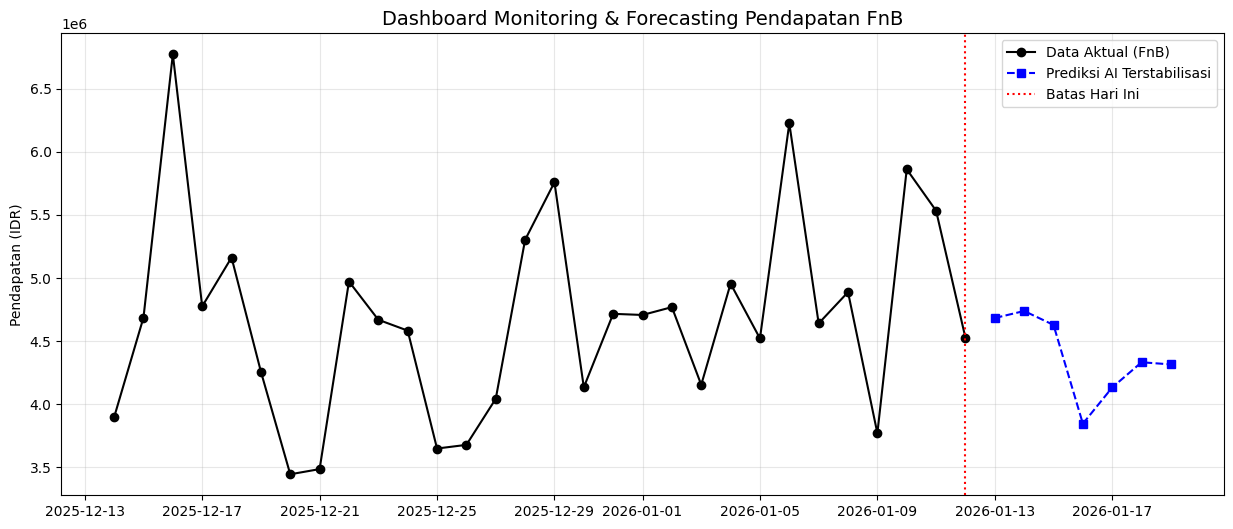

In [115]:
# Visualisasi Dashboard FnB
plt.figure(figsize=(15, 6))
hist_data_fnb = time_series_fnb.tail(30)

plt.plot(hist_data_fnb.index, hist_data_fnb['revenue_clean'],
         label='Data Aktual (FnB)', color='black', marker='o')

plt.plot(forecast_results_stable_fnb.index, forecast_results_stable_fnb['pred_revenue'],
         label='Prediksi AI Terstabilisasi', color='blue', linestyle='--', marker='s')

plt.axvline(x=hist_data_fnb.index[-1], color='red', linestyle=':', label='Batas Hari Ini')
plt.title('Dashboard Monitoring & Forecasting Pendapatan FnB', fontsize=14)
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()